# Looking at available TA, DIC, TA-DIC profiles in the southern ocean (southe of -50)

models are stored in UTILS under lom.py (names, colors)

In [189]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [190]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [191]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## Load dataframe made in GLODAPv2021comparison 

look here for how made:
https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/evalOutput/GLODAPv2021comparison_pipeline.ipynb

making new data for entire globe, also binning obs to lats & lons
it runs out of memory....
TD - need to fix that.

In [192]:
df = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL.csv')
df = df.sort_values(by = 'YR')
df

tDIC_SO = np.array(df['DIC'][:])
tALK_SO = np.array(df['ALK'][:])


tSAL_SO = np.array(df['SAL'][:])
tTEMP_SO = np.array(df['TEMP'][:])
tPRES_SO = np.array(df['PRES'][:])
tLAT_SO = np.array(df['LAT'][:])
tLON_SO = np.array(df['LON'][:])
tYEAR_SO = np.array(df['YR'])
tMONTH_SO = np.array(df['MONTH'])
tSECT_SO = np.array(df['SECT'])
tDP_SO = np.zeros_like(tSECT_SO)

### seasons
tSEAS_SO = np.zeros_like(tMONTH_SO)
tSEAS_SO[(tMONTH_SO == 12) | (tMONTH_SO <3)] = 1 #summer
tSEAS_SO[(tMONTH_SO >= 3) & (tMONTH_SO <6)] = 2 #autumn
tSEAS_SO[(tMONTH_SO >= 6) & (tMONTH_SO <9)] = 3 #winter
tSEAS_SO[(tMONTH_SO >= 9) & (tMONTH_SO <12)] = 4


## assign unique depth profiles numbers for ease of plotting

In [193]:
np.shape(np.unique(tLAT_SO))
np.shape(tLAT_SO)

uniq_LATS = np.unique(tLAT_SO)

dpcount = 1
for i in range(0, len(uniq_LATS)):
    slat = uniq_LATS[i]
    
    corlons = np.unique(tLON_SO[tLAT_SO == slat])
    for j in range(0, len(corlons)):
        slon = corlons[j]
        coryrs = np.unique(tYEAR_SO[(tLAT_SO == slat) & (tLON_SO == slon)])
        for k in range(0, len(coryrs)):
            syr = coryrs[k]
            cormos = np.unique(tMONTH_SO[(tLAT_SO == slat) & (tLON_SO == slon) & (tYEAR_SO == syr)])
            tw = (np.shape(cormos)[0])
            for l in range(0, len(cormos)):
                smo = cormos[l]
                tDP_SO[(tLAT_SO == slat) & (tLON_SO == slon) & (tYEAR_SO == syr) & (tMONTH_SO == smo)] = dpcount
                dpcount = dpcount+1

print('unique depth profiles in SO:')
print(dpcount-1)
tDP_SO = tDP_SO.astype(int)

unique depth profiles in SO:
3166


# match to grid

In [194]:
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 
print('SO south of -50 is 0:37, SO south of -30 is 0:50')
lats = tmesh['nav_lat'][:,0]
lons = tmesh['nav_lon'][0,:]
deps = tmesh['gdept_1d'][0,:]


SO south of -50 is 0:37, SO south of -30 is 0:50


In [195]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    arval = array[idx]
    return(idx, arval)


tX_SO = np.zeros_like(tTEMP_SO)
tY_SO = np.zeros_like(tTEMP_SO)
tZ_SO = np.zeros_like(tTEMP_SO)
tZdep_SO = np.zeros_like(tTEMP_SO)


for i in range(0,len(tYEAR_SO)):
    tlat = tLAT_SO[i]
    tlon = tLON_SO[i]
    tdep = tPRES_SO[i]
    idx, arval = find_nearest(lats, tlat)
    tY_SO[i] = idx
    idx, arval = find_nearest(lons, tlon)
    tX_SO[i] = idx
    idx, arval = find_nearest(deps, tdep)
    tZ_SO[i] = idx
    tZdep_SO[i] = arval

### add our new annotations to dataframe

In [196]:

df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO, tY_SO, tX_SO, tZ_SO, tZdep_SO, tDP_SO]).T
    # df = df.sort_values(by = tYEAR_SO)
df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT', 'Y', 'X', 'Z', 'Zdep', 'DP']
df.wheremade = 'evalOutput/TA-DIC_GLODAP.ipynb and evalOutput/GLODAPv2021comparison_pipeline.ipynb'
df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_togrid.csv')

## visualize raw data (all profiles) and geographic coverage

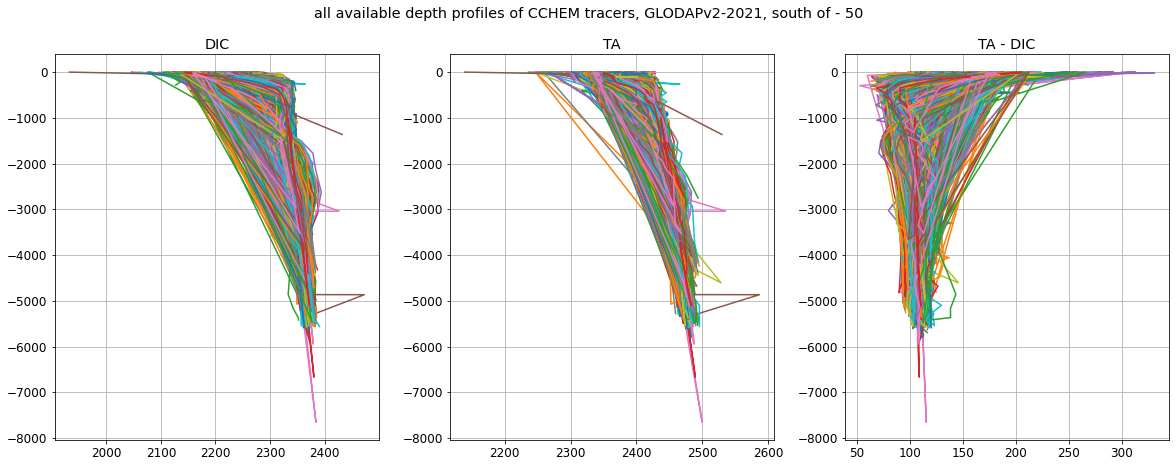

In [197]:
fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(15*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
    

for i in range(0, max(tDP_SO)+1):
    tDIC = tDIC_SO[tDP_SO == i]
    tALK = tALK_SO[tDP_SO == i]
    #ta - dic is TAD
    tTAD = tALK-tDIC
    tPRES = tPRES_SO[tDP_SO == i]
    axs[0].plot(tDIC,-tPRES)
    axs[1].plot(tALK,-tPRES)
    axs[2].plot(tTAD,-tPRES)
    
tits = ['DIC', 'TA', 'TA - DIC'] 
for i in range(0,3):
    axs[i].grid()
    axs[i].set_title(tits[i])
plt.suptitle('all available depth profiles of CCHEM tracers, GLODAPv2-2021, south of - 50')
plt.tight_layout()

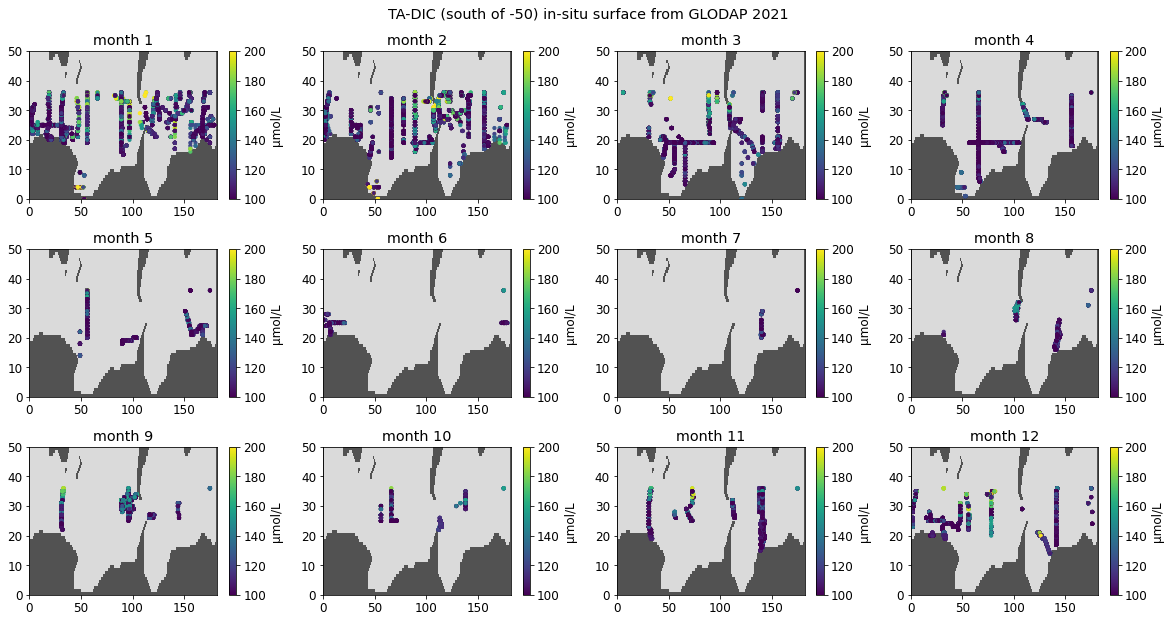

In [198]:
fact = 1.1
fig, axs = plt.subplots(3,4, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    q = axs[i].pcolormesh(tmask[0:50,:], vmin = -0.5, vmax = 1.5, cmap = 'Greys_r')
    q = axs[i].scatter(tX_SO[tMONTH_SO == i+1], tY_SO[tMONTH_SO == i+1],\
                       c = tALK_SO[tMONTH_SO == i+1]-tDIC_SO[tMONTH_SO == i+1], s = 10, vmin = 100, vmax = 200)
    plt.colorbar(q, ax = axs[i], label = 'µmol/L')
    axs[i].set_title(f'month {i+1}')
plt.suptitle('TA-DIC (south of -50) in-situ surface from GLODAP 2021')
plt.tight_layout()

    here are the (python) y-indices and latitude bounds for my latitude bands:
    band 0, -78.2 to -69.5, index 0 to 16
    band 1, -69.5 to -59.3, index 16 to 28
    band 2, -59.3 to -48.8, index 28 to 37
    band 3, -48.8 to -38.7, index 37 to 44
    band 4, -38.7 to -28.7, index 44 to 50

### visualize all available depth profiles, subdivided by latitude band and season (austral summer is DJF)

we've done a lot in the southern ocean but carbonate chemistry measurements are still hard to come by!

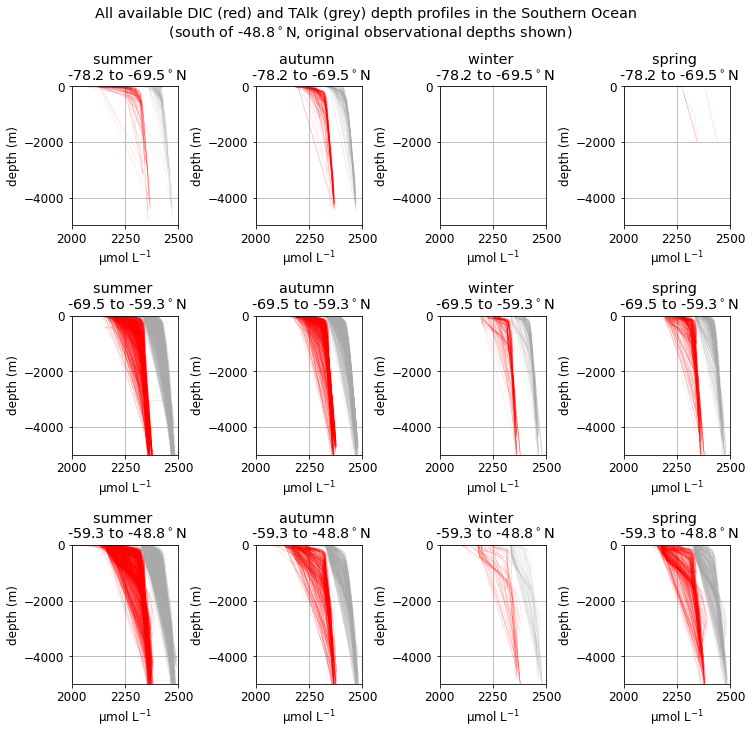

In [199]:
seasons = ['summer', 'autumn', 'winter', 'spring']

fact = 1.3
fig, axs = plt.subplots(3,4, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
        
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+4].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
         
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+8].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
        
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+4].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
         
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+8].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')
    
    
    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([2000,2500])
    axs[i].set_ylim([-5000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')

plt.suptitle('All available DIC (red) and TAlk (grey) depth profiles in the Southern Ocean \n (south of -48.8$^\circ$N, original observational depths shown)')
plt.tight_layout()

In [200]:
def plot_all_profs_alk(tfilt, ind):
    q = np.unique(tDP_SO[tfilt])
    storar = np.zeros([len(q),31]); storar[:] = np.nan
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tZdep_SO[tDP_SO == q[d]]
        tZ = (tZ_SO[tDP_SO == q[d]]).astype('int')
        storar[d,tZ] = tplt
        axs[ind].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)

    axs[ind].plot(np.nanmean(storar, axis = 0), -deps, color = 'k', linewidth = 2)
    return np.nanmean(storar, axis = 0)

def plot_all_profs_dic(tfilt, ind):
    q = np.unique(tDP_SO[tfilt])
    storar = np.zeros([len(q),31]); storar[:] = np.nan
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tZdep_SO[tDP_SO == q[d]]
        tZ = (tZ_SO[tDP_SO == q[d]]).astype('int')
        storar[d,tZ] = tplt
        axs[ind].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)

    axs[ind].plot(np.nanmean(storar, axis = 0), -deps, color = 'firebrick', linewidth = 2)
    return np.nanmean(storar, axis = 0)

## save the seasonal by-band observational averages in a nc


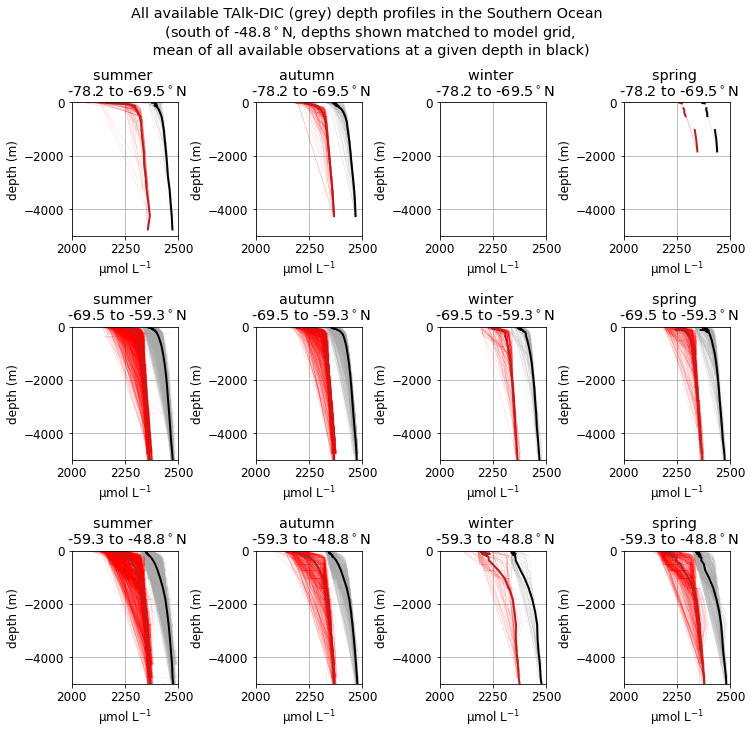

In [201]:
dic_obs = np.zeros([3,4,31])
alk_obs = np.zeros([3,4,31])
seasons = ['summer', 'autumn', 'winter', 'spring']

fact = 1.3
fig, axs = plt.subplots(3,4, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16); ind = i
    td = plot_all_profs_alk(tfilt, ind)
    alk_obs[0,i,:] = td
    td = plot_all_profs_dic(tfilt, ind)
    dic_obs[0,i,:] = td
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28); ind = i+4
    td = plot_all_profs_alk(tfilt, ind)
    alk_obs[1,i,:] = td
    td = plot_all_profs_dic(tfilt, ind)
    dic_obs[1,i,:] = td
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37); ind = i+8
    td = plot_all_profs_alk(tfilt, ind)
    alk_obs[2,i,:] = td
    td = plot_all_profs_dic(tfilt, ind)
    dic_obs[2,i,:] = td
# for i in range(0,4):

for i in range(0,4):
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([2000,2500])
    axs[i].set_ylim([-5000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')

plt.suptitle('All available TAlk-DIC (grey) depth profiles in the Southern Ocean \n (south of -48.8$^\circ$N, depths shown matched to model grid, \n mean of all available observations at a given depth in black)')
plt.tight_layout()

In [202]:


# define data with variable attributes
data_vars = {'dic':(['lat_band', 'season', 'z_index'], dic_obs,
                         {'units': 'µmol/L',
                          'long_name':'free-fall velocity'}),
             'ta':(['lat_band', 'season', 'z_index'], alk_obs,
                         {'units': 'µmol/L',
                          'long_name':'free-fall velocity'})            
            }

# define coordinates
coords = {'season': (['season'], np.arange(1,5,1)),\
         'lat_band': (['lat_band'], np.arange(0,3,1)),\
         'z_index': (['z_index'], np.arange(0,31,1))}

# define global attributes
attrs = {'made in':'evalOutput/TA-DIC_GLODAPOBS.ipynb',
         'latitude bands':'band 0, -78.2 to -69.5, index 0 to 16, band 1, -69.5 to -59.3, index 16 to 28 band 2, -59.3 to -48.8, index 28 to 37',
        'seasons': '1 is austral summer, 4 is spring'
        }
            
# create dataset
ds = xr.Dataset(data_vars=data_vars,
                coords=coords,
                attrs=attrs)

fn = f'./datasets/GLODAP_SO_regionalmeansDICTA.nc'
ds.to_netcdf(fn)

## looking at TA-DIC

In [203]:
def plot_all_profs(tfilt, ind):
    q = np.unique(tDP_SO[tfilt])
    storar = np.zeros([len(q),31]); storar[:] = np.nan
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]-tDIC_SO[tDP_SO == q[d]]
        tPRES = tZdep_SO[tDP_SO == q[d]]
        tZ = (tZ_SO[tDP_SO == q[d]]).astype('int')
        storar[d,tZ] = tplt
        axs[ind].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)

    axs[ind].plot(np.nanmean(storar, axis = 0), -deps, color = 'k', linewidth = 2)


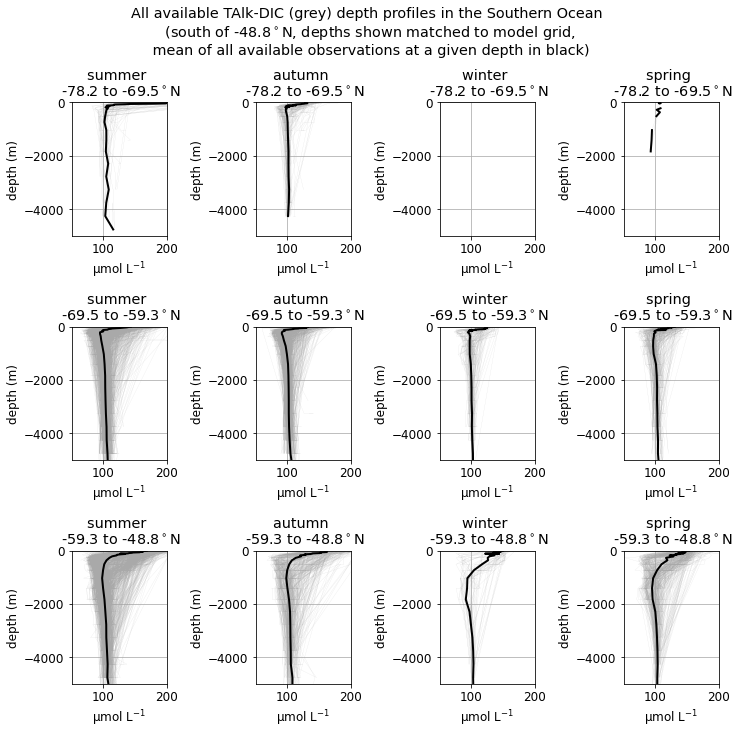

In [204]:
seasons = ['summer', 'autumn', 'winter', 'spring']

fact = 1.3
fig, axs = plt.subplots(3,4, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16); ind = i
    plot_all_profs(tfilt, ind)
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28); ind = i+4
    plot_all_profs(tfilt,ind)
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37); ind = i+8
    plot_all_profs(tfilt,ind)
# for i in range(0,4):

for i in range(0,4):
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([50,200])
    axs[i].set_ylim([-5000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')

plt.suptitle('All available TAlk-DIC (grey) depth profiles in the Southern Ocean \n (south of -48.8$^\circ$N, depths shown matched to model grid, \n mean of all available observations at a given depth in black)')
plt.tight_layout()

Text(0.5, 1.0, 'all DIC (red) and TA (black) averages in glodap \n (4 seasons, 3 latitude bands)')

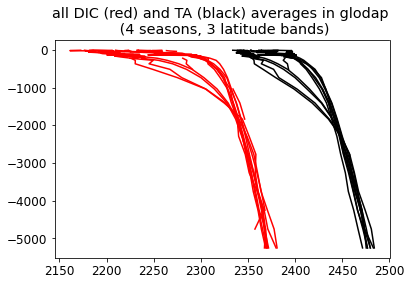

In [205]:
w = xr.open_dataset(f'./datasets/GLODAP_SO_regionalmeansDICTA.nc')
plt.figure()
for j in range(0,3):
    for i in range(0,4):
        plt.plot(w.dic[j,i,:],-deps, color = 'r')
        plt.plot(w.ta[j,i,:],-deps, color = 'k')
plt.title('all DIC (red) and TA (black) averages in glodap \n (4 seasons, 3 latitude bands)')

### from here to the plot we are extracting corresponding data from MODELS
- separate pipeline for CL models

In [206]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

#mask for averages
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
### cvol is the 3d mask
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]


In [207]:
def get_out(yrst, yrend, dtype, tr, baseDir, clq = False):
    print(tr)
    ## open
    
    if clq == False:
        ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
        w = xr.open_mfdataset(ylist)
        #seasonal averages
        DIC_mn = w.DIC.groupby('time_counter.season').mean('time_counter').values
        TA_mn = w.Alkalini.groupby('time_counter.season').mean('time_counter').values
        # DIC and TA averages by band and season
        DIC_model = np.zeros([3,4,31])
        for i in range(0,4):
            DIC_model[0,i,:] = np.ma.average(np.ma.average(DIC_mn[i,:,0:16,:], weights = cvol[:,0:16,:], axis = 2), axis = 1)
            DIC_model[1,i,:] = np.ma.average(np.ma.average(DIC_mn[i,:,16:28,:], weights = cvol[:,16:28,:], axis = 2), axis = 1)
            DIC_model[2,i,:] = np.ma.average(np.ma.average(DIC_mn[i,:,28:37,:], weights = cvol[:,28:37,:], axis = 2), axis = 1)
        TA_model = np.zeros([3,4,31])
        for i in range(0,4):
            TA_model[0,i,:] = np.ma.average(np.ma.average(TA_mn[i,:,0:16,:], weights = cvol[:,0:16,:], axis = 2), axis = 1)
            TA_model[1,i,:] = np.ma.average(np.ma.average(TA_mn[i,:,16:28,:], weights = cvol[:,16:28,:], axis = 2), axis = 1)
            TA_model[2,i,:] = np.ma.average(np.ma.average(TA_mn[i,:,28:37,:], weights = cvol[:,28:37,:], axis = 2), axis = 1)

    if clq:
        w = xr.open_dataset(glob.glob(f'{baseDir}/{tr}/*_ptrc_1998_2010_ave.nc')[0])
        DIC_mn = w.DIC.groupby('time_counter.season').mean('time_counter').values
        TA_mn = w.Alkalini.groupby('time_counter.season').mean('time_counter').values
        DIC_mn = np.ma.masked_array(DIC_mn, mask=[DIC_mn > 1e10])
        TA_mn = np.ma.masked_array(TA_mn, mask=[DIC_mn > 1e10])
        DIC_model = np.zeros([3,4,31])

        for i in range(0,4):
            DIC_model[0,i,:] = np.ma.average(np.ma.average(DIC_mn[i,:,0:16,:], weights = cvol[:,0:16,:], axis = 2), axis = 1)

            DIC_model[1,i,:] = np.ma.average(np.ma.average(DIC_mn[i,:,16:28,:], weights = cvol[:,16:28,:], axis = 2), axis = 1)
            DIC_model[2,i,:] = np.ma.average(np.ma.average(DIC_mn[i,:,28:37,:], weights = cvol[:,28:37,:], axis = 2), axis = 1)
        TA_model = np.zeros([3,4,31])
        for i in range(0,4):
            TA_model[0,i,:] = np.ma.average(np.ma.average(TA_mn[i,:,0:16,:], weights = cvol[:,0:16,:], axis = 2), axis = 1)
            TA_model[1,i,:] = np.ma.average(np.ma.average(TA_mn[i,:,16:28,:], weights = cvol[:,16:28,:], axis = 2), axis = 1)
            TA_model[2,i,:] = np.ma.average(np.ma.average(TA_mn[i,:,28:37,:], weights = cvol[:,28:37,:], axis = 2), axis = 1)
        print(DIC_model[0,i,:])
            # define data with variable attributes
    data_vars = {'dic':(['lat_band', 'season', 'z_index'], DIC_model,
                             {'units': 'µmol/L',
                              'long_name':'free-fall velocity'}),
                 'ta':(['lat_band', 'season', 'z_index'], TA_model,
                             {'units': 'µmol/L',
                              'long_name':'free-fall velocity'})            
                }

    # define coordinates
    coords = {'season': (['season'], np.arange(1,5,1)),\
             'lat_band': (['lat_band'], np.arange(0,3,1)),\
             'z_index': (['z_index'], np.arange(0,31,1))}

    # define global attributes
    attrs = {'made in':'evalOutput/TA-DIC_GLODAPOBS.ipynb',
             'latitude bands':'band 0, -78.2 to -69.5, index 0 to 16, band 1, -69.5 to -59.3, index 16 to 28 band 2, -59.3 to -48.8, index 28 to 37',
            'seasons': '1 is austral summer, 4 is spring',
             'model': 'TOM12_TJ_1ASA, years 1972-2020' 
            }

    # create dataset
    ds = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)

    fn = f'./datasets/{tr}_seasonal_SO_DICTA_{yrst}_{yrend}.nc'
    ds.to_netcdf(fn)

In [208]:
#1972- 2020
runs = ['TOM12_TJ_1ASA','TOM12_DW_WE43','TOM12_DW_GA01', 'TOM10_CL_LIG9', 'TOM10_CL_LIGD',\
       'TOM12_RW_3G20', 'TOM12_RW_3G07', 'TOM12_RW_3G09', 'TOM12_RW_3G35']

yrst = [1998, 1998, 1998, 1998, 1998, 1952, 1952, 1952, 1952]
yren = [2010, 2010, 2010, 2010, 2010, 1959, 1959, 1959, 1959]
tclq = [False, False, False, True, True, False, False, False, False]

horse = False
if horse:
    for i in range(0, len(runs)):
        if tclq[i]:
            tr = runs[i]; st = yrst[i]; en = yren[i]
            baseDir = (lom.mod[runs[i]]['basedir'])
            print(baseDir)
            get_out(st, en, 'ptrc_T', tr, baseDir, clq = tclq[i] )

In [209]:
def go_plot(model, tcol, name):
    for i in range(0,4):
        axs[i].plot(model.dic[0,i,:]*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = '-', label = f'{name} DIC')
        axs[i].plot(model.ta[0,i,:]*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = ':')
    for i in range(0,4):
        axs[i+4].plot(model.dic[1,i,:]*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = '-')
        axs[i+4].plot(model.ta[1,i,:]*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = ':')
    for i in range(0,4):
        axs[i+8].plot(model.dic[2,i,:]*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = '-')
        axs[i+8].plot(model.ta[2,i,:]*1e6,-deps, color = tcol,  linewidth = 1.5, linestyle = ':')   

def go_plotTAD(model, tcol, name):
    for i in range(0,4):
        axs[i].plot((model.ta[0,i,:]-model.dic[0,i,:])*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = '-', label = f'{name}')
    for i in range(0,4):
        axs[i+4].plot((model.ta[1,i,:]-model.dic[1,i,:])*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = '-')
    for i in range(0,4):
        axs[i+8].plot((model.ta[2,i,:]-model.dic[2,i,:])*1e6,-deps, color = tcol, linewidth = 1.5, linestyle = '-')


## plot our painfully-earned thing

In [210]:
runs = ['TOM12_TJ_1ASA','TOM12_DW_WE43','TOM12_DW_GA01', 'TOM10_CL_LIG9', 'TOM10_CL_LIGD',\
       'TOM12_RW_3G20', 'TOM12_RW_3G07', 'TOM12_RW_3G09', 'TOM12_RW_3G35']

yrst = [1998, 1998, 1998, 1998, 1998, 1952, 1952, 1952, 1952]
yren = [2010, 2010, 2010, 2010, 2010, 1959, 1959, 1959, 1959]



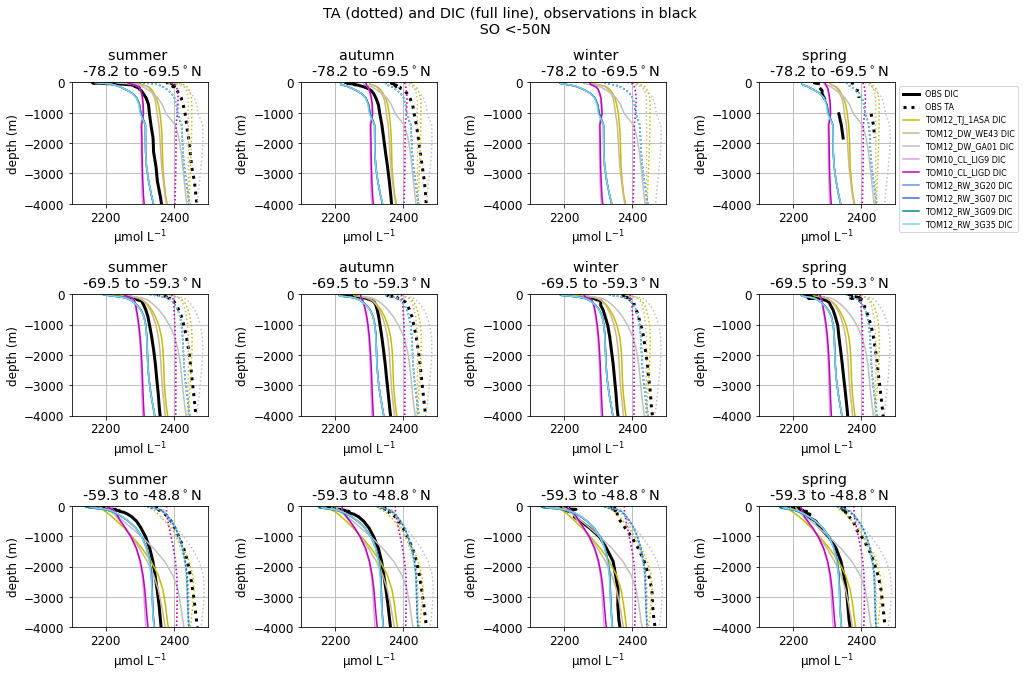

In [211]:
reload(lom)
glodap = xr.open_dataset(f'./datasets/GLODAP_SO_regionalmeansDICTA.nc')
fact = 1.2
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


for i in range(0,4):
    axs[i].plot(glodap.dic[0,i,:],-deps, color = 'k', linewidth = 3, linestyle = '-', label = 'OBS DIC')
    axs[i].plot(glodap.ta[0,i,:],-deps, color = 'k', linewidth = 3, linestyle = ':', label = 'OBS TA')
for i in range(0,4):
    axs[i+4].plot(glodap.dic[1,i,:],-deps, color = 'k', linewidth = 3, linestyle = '-')
    axs[i+4].plot(glodap.ta[1,i,:],-deps, color = 'k', linewidth = 3, linestyle = ':')
for i in range(0,4):
    axs[i+8].plot(glodap.dic[2,i,:],-deps, color = 'k', linewidth = 3,  linestyle = '-')
    axs[i+8].plot(glodap.ta[2,i,:],-deps, color = 'k', linewidth = 3, linestyle = ':')
    
for r in range(0, len(runs)):
    tdat = glob.glob(f'./datasets/{runs[r]}*seasonal*{yrst[r]}*.nc')[0]
    tmod = xr.open_dataset(tdat)
    modnam = runs[r]
    modcol = lom.mod[modnam]['color']
    go_plot(tmod, modcol, modnam)

for i in range(0,4):
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([2100,2500])
    axs[i].set_ylim([-4000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')
    axs[3].legend(fontsize = 8, bbox_to_anchor = [1, 1])
    

plt.suptitle('TA (dotted) and DIC (full line), observations in black \n SO <-50N')
plt.tight_layout()

## TA-DIC profiles

we have too-low TA-DIC at depth. So any upwelling will crank the wrong water up. 

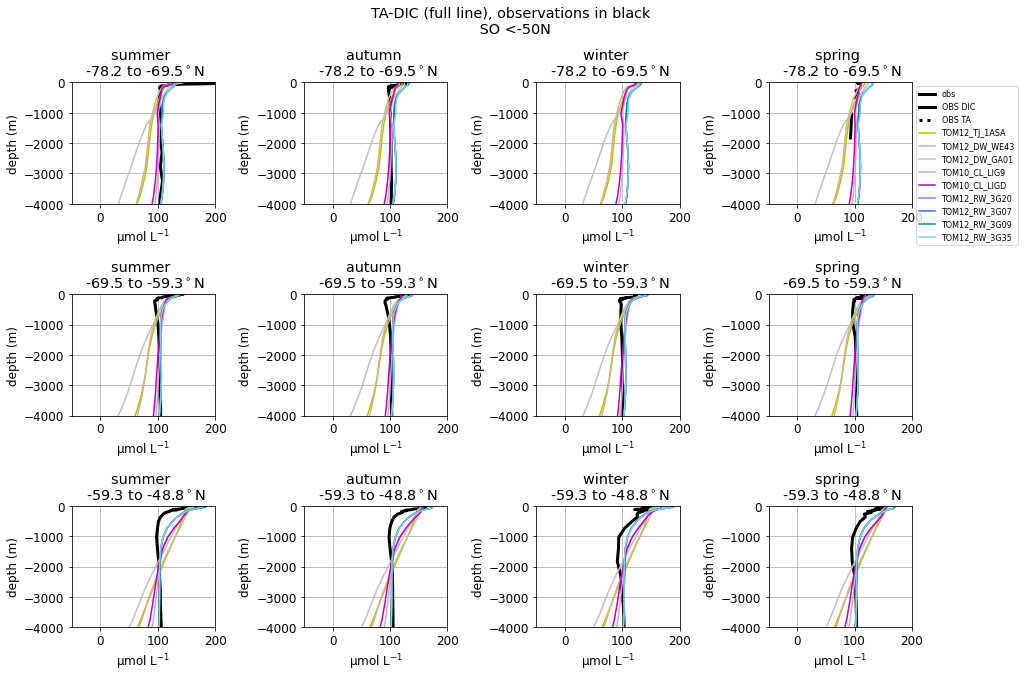

In [212]:
glodap = xr.open_dataset(f'./datasets/GLODAP_SO_regionalmeansDICTA.nc')
fact = 1.2
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,4):
    axs[i].plot((glodap.ta[0,i,:]-glodap.dic[0,i,:]),-deps, color = 'k', linewidth = 3, linestyle = '-', label = f'obs')
for i in range(0,4):
    axs[i+4].plot((glodap.ta[1,i,:]-glodap.dic[1,i,:]),-deps, color = 'k', linewidth = 3, linestyle = '-')
for i in range(0,4):
    axs[i+8].plot((glodap.ta[2,i,:]-glodap.dic[2,i,:]),-deps, color = 'k', linewidth = 3, linestyle = '-')


for i in range(0,4):
    axs[i].plot(glodap.dic[0,i,:],-deps, color = 'k', linewidth = 3, linestyle = '-', label = 'OBS DIC')
    axs[i].plot(glodap.ta[0,i,:],-deps, color = 'k', linewidth = 3, linestyle = ':', label = 'OBS TA')
for i in range(0,4):
    axs[i+4].plot(glodap.dic[1,i,:],-deps, color = 'k', linewidth = 3, linestyle = '-')
    axs[i+4].plot(glodap.ta[1,i,:],-deps, color = 'k', linewidth = 3, linestyle = ':')
for i in range(0,4):
    axs[i+8].plot(glodap.dic[2,i,:],-deps, color = 'k', linewidth = 3,  linestyle = '-')
    axs[i+8].plot(glodap.ta[2,i,:],-deps, color = 'k', linewidth = 3, linestyle = ':')
    
for r in range(0, len(runs)):
    tdat = glob.glob(f'./datasets/{runs[r]}*seasonal*{yrst[r]}*.nc')[0]
    tmod = xr.open_dataset(tdat)
    modnam = runs[r]
    modcol = lom.mod[modnam]['color']
    go_plotTAD(tmod, modcol, modnam)

for i in range(0,4):
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([-50,200])
    axs[i].set_ylim([-4000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')
    axs[3].legend(fontsize = 8, bbox_to_anchor = [1, 1])
    

plt.suptitle('TA-DIC (full line), observations in black \n SO <-50N')
plt.tight_layout()